# Final.ipynb

## Running the Code
All of the necessary imports have been made in the first cell. In order to do so, the /code/ directory is added to the system path with the sys module.

Each cell is prepared to be run without further scripting or preparation. If plots are not showing up, simply execute the cells in sequence or use the `Run all cells` command from the notebook's `Run` dropdown menu.

## What's Included
The following cells will demonstrate:
- Listing out any markdown files found in experiment directory
- Preparing, processing, and plotting the full set of data as X and Y displacements in a single figure.
- A figure with all of the trial's FFTs presented in a single plot.
- A plot of the IFFT for the mean of the experimental FFTs



# Bibliography
- [Handling GPS with Python](https://florianwilhelm.info/2016/07/handling_gps_data_with_python/)
- [Calculate Distance Between GPS Points in Python](https://janakiev.com/blog/gps-points-distance-python/)
- [Matplotlib List of Colormaps](https://matplotlib.org/stable/gallery/color/named_colors.html)
- [Discrete Fourier Transform ](https://numpy.org/doc/2.1/reference/routines.fft.html)
- [IFFT | Numpy](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html)
- [Understanding FFT Windows](https://www.egr.msu.edu/classes/me451/me451_labs/Fall_2013/Understanding_FFT_Windows.pdf)
- [Understanding FFTs and Windowing](https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf)
- [FFT normalisation - Reddit/r/DSP](https://www.reddit.com/r/DSP/comments/htxvn8/fft_normalisation/)
- [Scaling of the DFT and Some More of Its Noteworthy Properties](https://appliedacousticschalmers.github.io/scaling-of-the-dft/AES2020_eBrief/)
- [FFT Normalization](https://www.hep.ucl.ac.uk/~rjn/saltStuff/fftNormalisation.pdf)
- [Numpy Documentation](https://numpy.org/doc/stable/user/)
- [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)
- [Matplotlib Documentation](https://matplotlib.org/stable/users/index.html)
- [Principle Component Analysis & Python](https://builtin.com/machine-learning/pca-in-python)
- [Resampling Data with Python | numpy.interp](https://numpy.org/doc/2.1/reference/generated/numpy.interp.html)
- [Resample and Interpolate Your Time Series Data](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/)


In [1]:
%matplotlib inline

# Get ahold of some imports

import sys
import os
import re 
import numpy as np
import importlib
from matplotlib import cm, colormaps
import matplotlib.pyplot as plt

# import modules from /code/
# Add the relative path to the 'code' directory
sys.path.append("../../code/")
import utils
from final import filter_markdown_files, parse_markdown, convert_f_to_k
from final import rotate_to_x_axis, resample_df_to_2n_segments
from final import apply_fft, apply_ifft


In [2]:
# Print out the markdown files

# But first, where in the world are we?
print(os.getcwd())    # Print current working directory

# Our data is in /avgagliardo/data/, can we list out the markdown files?
data_dir = "../../data/AVG002_gps_sine_walk/experimental_data"
filter_str = "AVG002_gps_sine_walk"

# Get the list of markdown files for our experimental data
sorted_files = filter_markdown_files(data_dir, filter_str)

# print them cleanly
print("\nMarkdown Files")
print(15*"-")
for trial, fname in enumerate(sorted_files):
    md = parse_markdown(data_dir+'/'+fname, 'Temperature')
    # print(md)
    print(f"Trial #{trial}: {fname}")
    
    




C:\Users\thean\schoolspace\phy410\exams\final-branches\CP1-24-final\avgagliardo\documentation\final_docs

Markdown Files
---------------
Trial #0: AVG002_gps_sine_walk_0.md
Trial #1: AVG002_gps_sine_walk_1.md
Trial #2: AVG002_gps_sine_walk_2.md
Trial #3: AVG002_gps_sine_walk_3.md
Trial #4: AVG002_gps_sine_walk_4.md
Trial #5: AVG002_gps_sine_walk_5.md
Trial #6: AVG002_gps_sine_walk_6.md
Trial #7: AVG002_gps_sine_walk_7.md
Trial #8: AVG002_gps_sine_walk_8.md
Trial #9: AVG002_gps_sine_walk_9.md
Trial #10: AVG002_gps_sine_walk_10.md
Trial #11: AVG002_gps_sine_walk_11.md


In [3]:
# Now we are going to want to plot them all at once

def plot_multiple_datasets(data_list,
                           title="Multiple Datasets Plot",
                           xlabel="X-Displacement (meters)",
                           ylabel="Y-Displacement (meters)",
                           plot_fit=False,
                           legend_label="Experiment #",
                           alpha=0.55,
                           scatter_size=15):
    """
    Plot multiple datasets from a list of dictionaries, display temperatures, and preserve the legend.

    Args:
        data_list (list): A list of dictionaries, each with keys 'x', 'y', and optionally 'Fitted Sine'.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        plot_fit (bool): Whether to plot the fitted curve.
        legend_label (str): Base label for the legend.
        alpha (float): Transparency for the scatter points.
        scatter_size (int): Size of the scatter points.
    """
    fig, ax = plt.subplots(figsize=(15, 9))

    # Generate linearly spaced colors
    colormap = colormaps['plasma']
    num_datasets = len(data_list)
    colors = [colormap(i / (num_datasets - 1)) for i in range(num_datasets)]

    # Adjust margins for text on the left and the legend on the right
    plt.subplots_adjust(left=0.3, right=0.8)

    # Build the temperature text to display on the left
    temp_text_lines = []

    # Plot all data and preserve legend entries
    legend_entries = []
    for i, dataset in enumerate(data_list):
        x = dataset.get('x')
        y = dataset.get('y')
        fit = dataset.get('Fitted Sine')
        label = dataset.get('label', f"{legend_label} {i+1}")

        # Mock temperature data extraction (replace this with actual function)
        md_name = f"../../data/AVG002_gps_sine_walk/experimental_data/AVG002_gps_sine_walk_{i}.md"
        md_temp = parse_markdown(md_name, "Temperature")
        temp_k = convert_f_to_k(md_temp)
        temp_k_str = f"{temp_k:.2f} K"
        temp_text_lines.append(f"Trial {i+1}: {temp_k_str}")

        if x is None or y is None:
            raise ValueError(f"Dataset {i+1} must contain 'x' and 'y' keys with NumPy arrays.")

        color = colors[i]

        # Scatter plot
        scatter = ax.scatter(x, y, color=color, alpha=alpha, s=scatter_size, label=label)
        legend_entries.append(scatter)

        # Plot the fitted curve if requested
        if plot_fit and fit is not None:
            fit_label = f"Fitted Curve {i+1}"
            line, = ax.plot(x, fit, linestyle="--", color=color, label=fit_label)
            legend_entries.append(line)

    # Center the temperature text vertically on the left side
    y_step = 0.05  # Vertical spacing for each line of text
    start_y = 0.5 + (len(temp_text_lines) / 2) * y_step  # Start at center and adjust for number of lines
    
    # Display the temperature text on the left
    for i, line in enumerate(temp_text_lines):
        y_pos = start_y - i * y_step  # Adjust vertical position
        plt.text(-0.25, y_pos, line, fontsize=8, transform=ax.transAxes, va="center")

    # Add the legend outside the plot on the right
    ax.legend(handles=legend_entries, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10, title="Legend")

    # Set title, labels, and grid
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

    plt.show()


    




12


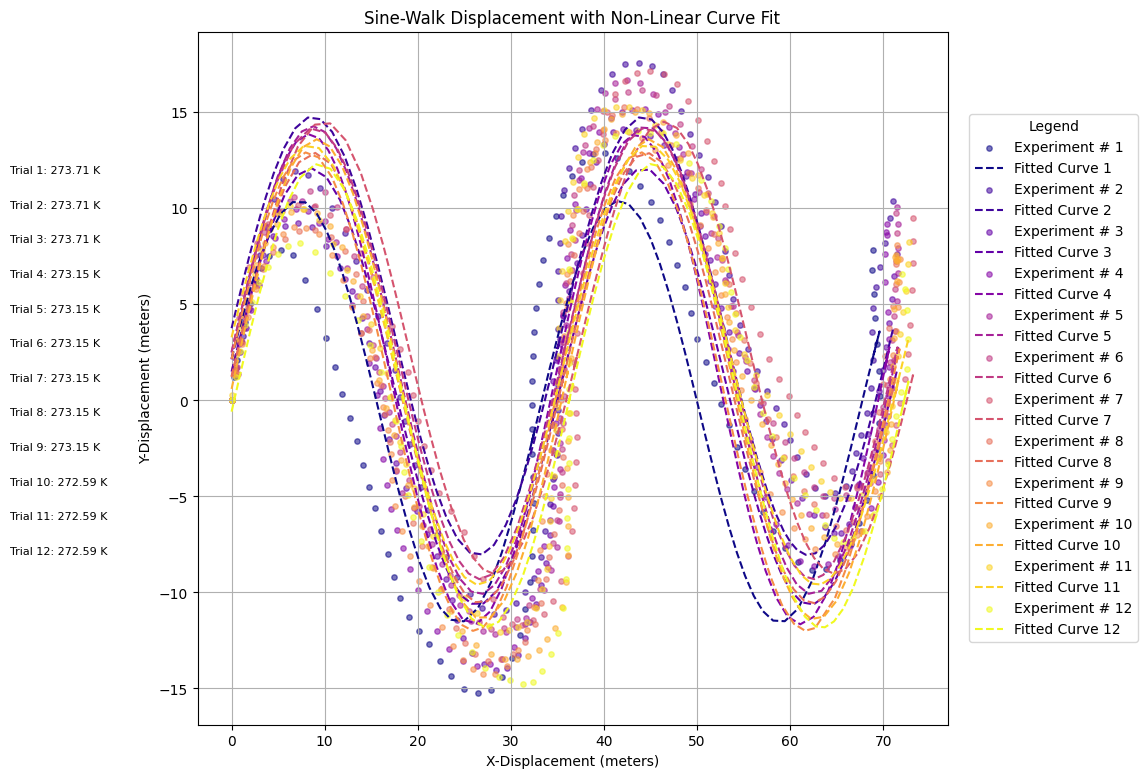

In [4]:
# LOAD AND PLOT A BUNCH OF DATA FRAMES AT ONCE

# Our data is in /avgagliardo/data/, can we list out the markdown files?
data_dir = "../../data/AVG002_gps_sine_walk/experimental_data"
filter_str = "AVG002_gps_sine_walk"

# Get the list of markdown files for our experimental data
sorted_files = filter_markdown_files(data_dir, filter_str)


# create a list for all our data frames
dfs = []
# number of points to resample
n = 6

for fname in sorted_files:
    fname  = fname.split('.')[0]
    df_pre = utils.import_csv("../../data/AVG002_gps_sine_walk/experimental_data/" + fname + ".csv")
    clean_rf = df_pre.iloc[4:, :3 ].reset_index(drop=True)
    # print(clean_rf)
    resampled_rf = resample_df_to_2n_segments(clean_rf, n)
    #print(resampled_rf)
    rot_rf = rotate_to_x_axis(clean_rf, resample=False, n=6, fit_curve=True)
    # print(rot_rf)
    # Create DataFrame
    dfs.append(rot_rf)


print(len(dfs))



title="Sine-Walk Displacement with Non-Linear Curve Fit"
xlabel="X-Displacement (meters)"
ylabel="Y-Displacement (meters)"
plot_fit = True
legend_label="Experiment #"

plot_multiple_datasets(dfs, title, xlabel, ylabel, plot_fit, legend_label)

# check if the raw frame has been loaded
# rf = test_raw_dataframe

# prune off the first few frames since they can be noisy

# rotated_data = rotate_to_x_axis(clean_rf)


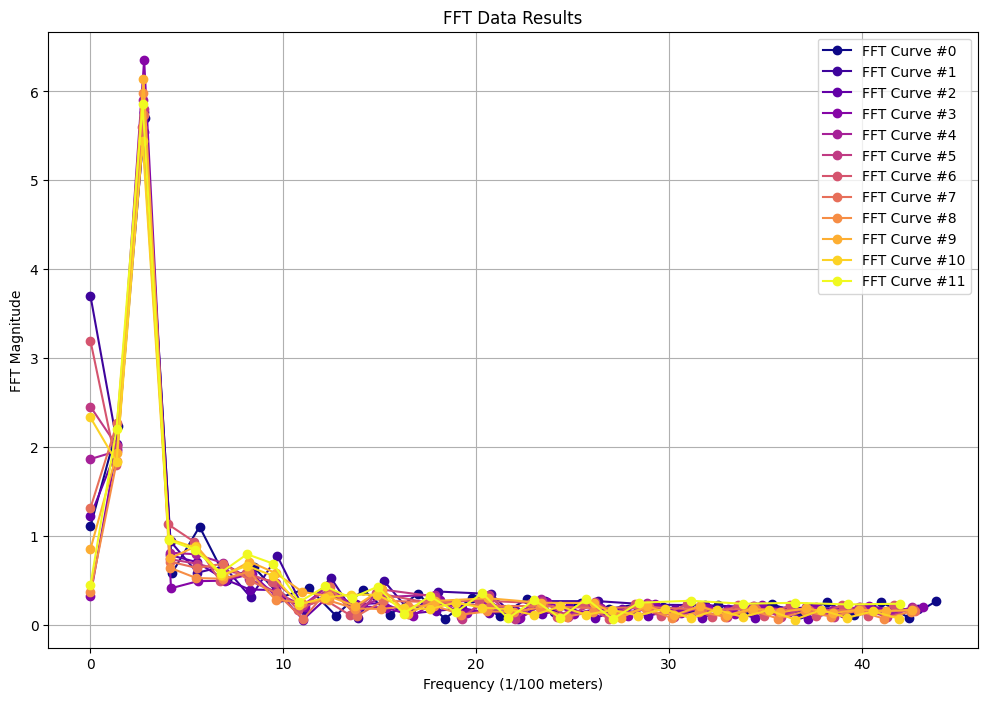

In [5]:
#Apply the FFT to the whole dataset, and plot
def process_and_plot_ffts(dataframes, threshold=0.01, title="FFT Data Results", xlabel="Frequency (1/100 meters)", ylabel="FFT Magnitude"):
    """
    Apply FFT to a list of DataFrames and plot all the resulting FFT magnitudes on the same graph,
    with rescaled y-axis and omission of insignificant x-axis tail.

    Args:
        dataframes (list): List of pandas DataFrames with 'x' and 'y' columns.
        threshold (float): Fraction of the max magnitude below which frequencies are considered insignificant.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    n = 6  # Number of segments as 2^n
    plt.figure(figsize=(12, 8))

    # Generate linearly spaced colors
    colormap = colormaps['plasma']
    num_datasets = len(dataframes)
    colors = [colormap(i / (num_datasets - 1)) for i in range(num_datasets)]

    for i, data in enumerate(dataframes):
        # Resample the DataFrame
        data = resample_df_to_2n_segments(data, n)
        
        # Apply FFT
        frequencies, fft_values = apply_fft(data)

        # Update color
        color = colors[i]
        
        # Calculate magnitudes
        magnitudes = np.abs(fft_values)
        positive_frequencies = np.array(frequencies[:len(frequencies)//2])
        positive_magnitudes = np.array(magnitudes[:len(magnitudes)//2])

        # Determine cutoff where magnitudes are significant
        max_magnitude = positive_magnitudes.max()
        significant_indices = (positive_magnitudes > (threshold * max_magnitude)).astype(bool)

        # Apply threshold filter
        filtered_frequencies = positive_frequencies[significant_indices]
        filtered_magnitudes = positive_magnitudes[significant_indices]

        # Plot FFT results with markers
        plt.plot(filtered_frequencies, filtered_magnitudes, color=color, marker='o', linestyle='-', label=f"FFT Curve #{i}")

    # Rescale y-axis to logarithmic for better visibility
    # plt.yscale('log')

    # Add plot details
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()





# Example usage
process_and_plot_ffts(dfs)








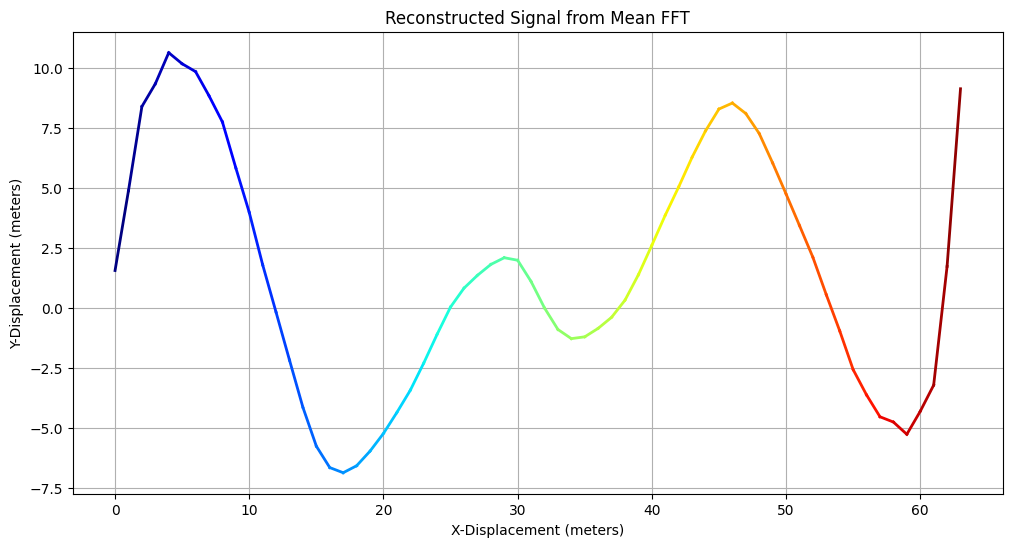

In [6]:
## Take a mean and run the IFFT


def process_and_plot_mean_ifft(dataframes, threshold=0.01, n=6):
    """
    Compute the mean FFT of multiple datasets, apply IFFT, and plot the reconstructed signal
    with a color gradient using the jet colormap.

    Args:
        dataframes (list): List of pandas DataFrames with 'x' and 'y' columns.
        threshold (float): Fraction of the max magnitude below which frequencies are considered insignificant.
        n (int): Number of resampling segments as 2^n.
    """
    fft_values_list = []  # To store FFT values

    for data in dataframes:
        # Resample the DataFrame
        data = resample_df_to_2n_segments(data, n)

        # Apply FFT
        frequencies, fft_values = apply_fft(data)

        # Calculate magnitudes and filter significant FFT values
        magnitudes = np.abs(fft_values)
        positive_fft_values = fft_values[:len(fft_values)//2]

        # Determine significant indices
        max_magnitude = magnitudes[:len(magnitudes)//2].max()
        significant_indices = magnitudes[:len(magnitudes)//2] > (threshold * max_magnitude)

        # Filter and store significant FFT values
        fft_values_list.append(positive_fft_values[significant_indices])

    # Align FFT values by zero-padding and compute the mean FFT
    max_length = max(len(fft) for fft in fft_values_list)
    aligned_fft_values = np.zeros((len(fft_values_list), max_length), dtype=complex)

    for i, fft in enumerate(fft_values_list):
        aligned_fft_values[i, :len(fft)] = fft  # Zero-padding

    mean_fft_values = np.mean(aligned_fft_values, axis=0)

    # Reconstruct signal using IFFT
    mean_fft_full = np.zeros(2 * max_length, dtype=complex)
    mean_fft_full[:max_length] = mean_fft_values
    mean_fft_full[-max_length:] = np.conj(mean_fft_values[::-1])  # Symmetry for real signals

    reconstructed_signal = apply_ifft(mean_fft_full)

    # Plot the reconstructed signal with jet colormap gradient
    plt.figure(figsize=(12, 6))

    # Generate colors using the jet colormap
    colormap = colormaps["jet"]
    num_points = len(reconstructed_signal)
    colors = [colormap(i / (num_points - 1)) for i in range(num_points)]

    # Plot with colors changing along the curve
    for i in range(num_points - 1):
        plt.plot([i, i + 1], [reconstructed_signal[i], reconstructed_signal[i + 1]],
                 color=colors[i], linewidth=2)

    plt.title("Reconstructed Signal from Mean FFT")
    plt.xlabel("X-Displacement (meters)")
    plt.ylabel("Y-Displacement (meters)")
    plt.grid(True)
    plt.show()



################
process_and_plot_mean_ifft(dfs, threshold=0.01)
